<a href="https://colab.research.google.com/github/susie682/Infosys722--Assignment-4-BDAS/blob/main/7_3_Search_for_pattern.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# =========================
# 0) Imports & Drive mount
# =========================
import os, warnings, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

warnings.filterwarnings("ignore")
SEED = 42
np.random.seed(SEED)

# Mount Google Drive (idempotent)
try:
    from google.colab import drive  # type: ignore
    if not os.path.ismount("/content/drive"):
        drive.mount("/content/drive")
except Exception:
    pass

ROOT = "/content/drive/MyDrive/Infosys 722"
TAB_DIR = os.path.join(ROOT, "tables")
FIG_DIR = os.path.join(ROOT, "figs")
os.makedirs(TAB_DIR, exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)

CSV_PATH = os.path.join(TAB_DIR, "CrimeData2017_reduced_projected.csv")
print("CSV_PATH:", CSV_PATH)
print("FIG_DIR :", FIG_DIR)


Mounted at /content/drive
CSV_PATH: /content/drive/MyDrive/Infosys 722/tables/CrimeData2017_reduced_projected.csv
FIG_DIR : /content/drive/MyDrive/Infosys 722/figs


In [ ]:
# =========================
# 1) Load & basic hygiene
# =========================
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"CSV not found at:\n{CSV_PATH}\nPlease check the path.")

df = pd.read_csv(CSV_PATH)
print("Loaded shape:", df.shape)
print("Columns:", list(df.columns))

# Ensure required columns
need_any = ["District", "Total", "Month"]
for c in need_any:
    if c not in df.columns:
        raise ValueError(f"Missing required column: {c}")

# District formatting
df["District"] = df["District"].astype(str).str.strip()

# Year & Month: dataset is 2017 only in this project scope
if "Year" not in df.columns:
    df["Year"] = 2017
df["Year"] = pd.to_numeric(df["Year"], errors="coerce").fillna(2017).astype(int)
df["Month"] = pd.to_numeric(df["Month"], errors="coerce").astype(int)

# Build a YYYY-MM label for plotting/splitting
df["_ym"] = pd.to_datetime(dict(year=df["Year"], month=df["Month"], day=1)).dt.strftime("%Y-%m")

# Next-month count (target for hotspot ranking)
if "y_count_next" in df.columns:
    df["y_next"] = pd.to_numeric(df["y_count_next"], errors="coerce")
else:
    df = df.sort_values(["District", "Year", "Month"])
    df["y_next"] = df.groupby("District")["Total"].shift(-1)

df = df.dropna(subset=["y_next"]).copy()
df["y_next"] = df["y_next"].astype(float)

# ========== Hotspot label (top-10% by next-month count per calendar month) ==========
K = 0.10  # top-10%

def label_hotspots(group):
    n = group["District"].nunique()
    k = max(int(math.ceil(K * n)), 1)
    order = group.sort_values("y_next", ascending=False)
    top_ids = set(order["District"].head(k))
    return group["District"].isin(top_ids).astype(int)

df = df.sort_values(["Year", "Month", "District"])
df["y_hotspot"] = df.groupby(["Year", "Month"], group_keys=False).apply(label_hotspots)

print("Positive rate (overall hotspot share):", df["y_hotspot"].mean().round(4))


Loaded shape: (267, 15)
Columns: ['District', 'Month', 'Total', 'District_Month_ArrestRate', 'District_Month_DomesticRate', 'NightShare_DistMonth', 'OutdoorShare_DistMonth', 'Roll3Mean_DistMonth', 'y_count_next', 'District_Month_ArrestRate_logit', 'District_Month_DomesticRate_logit', 'NightShare_DistMonth_logit', 'OutdoorShare_DistMonth_logit', 'Roll3Mean_DistMonth_log1p', 'y_count_next_log1p']
Positive rate (overall hotspot share): 0.1358


In [ ]:
# =========================
# 2) Train/Test split by time
# =========================
timeline = df[["_ym", "Year", "Month"]].drop_duplicates().sort_values(["Year", "Month"])
unique_ym = list(timeline["_ym"])
if len(unique_ym) < 4:
    raise ValueError("Not enough months to form a train/test split.")

# Train = months except last 3; Test = last 3 (Sep–Nov 2017 in this dataset)
test_months = unique_ym[-3:]
train_months = unique_ym[:-3]
print("Train months:", train_months)
print("Test months :", test_months)

df["Split"] = np.where(df["_ym"].isin(test_months), "Test", "Train")
train = df[df["Split"] == "Train"].copy()
test  = df[df["Split"] == "Test"].copy()
print("Train rows:", len(train), " Test rows:", len(test))


Train months: ['2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08']
Test months : ['2017-09', '2017-10', '2017-11']
Train rows: 177  Test rows: 66


In [ ]:
# =========================
# 3) Feature matrix
# =========================
# Candidate features (use what exists in the CSV; ignore the rest gracefully)
preferred_feats = [
    "Roll3Mean_DistMonth_log1p",
    "NightShare_DistMonth_logit",
    "OutdoorShare_DistMonth_logit",
    "District_Month_ArrestRate_logit",
    "District_Month_DomesticRate_logit",
    "Total"  # keep raw scale as a simple baseline signal
]
Xcols = [c for c in preferred_feats if c in df.columns]
if len(Xcols) == 0:
    raise ValueError("No expected feature columns found; please check your CSV columns.")

ycol = "y_hotspot"

X_train = train[Xcols].astype(float).copy()
y_train = train[ycol].astype(int).copy()
X_test  = test[Xcols].astype(float).copy()
y_test  = test[ycol].astype(int).copy()

print("Features used:", Xcols)
print("X_train shape:", X_train.shape, " X_test shape:", X_test.shape)


Features used: ['Roll3Mean_DistMonth_log1p', 'NightShare_DistMonth_logit', 'OutdoorShare_DistMonth_logit', 'District_Month_ArrestRate_logit', 'District_Month_DomesticRate_logit', 'Total']
X_train shape: (177, 6)  X_test shape: (66, 6)


In [ ]:
# =========================
# 4) Model definitions
# =========================
# (A) Decision Tree (C&R equivalent)
dt = DecisionTreeClassifier(
    criterion="gini",
    max_depth=6,
    min_samples_split=10,
    random_state=SEED
)

# (B) Random Forest
rf = RandomForestClassifier(
    n_estimators=300,
    max_features="sqrt",
    max_depth=None,
    random_state=SEED,
    n_jobs=-1
)

# (C) XGBoost (optional)
try:
    from xgboost import XGBClassifier  # type: ignore
    xgb = XGBClassifier(
        learning_rate=0.10,
        n_estimators=200,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        random_state=SEED,
        n_jobs=-1
    )
    HAS_XGB = True
except Exception:
    print("[Info] XGBoost not installed in this runtime; skipping XGB model.")
    HAS_XGB = False
    xgb = None

# (D) MLP (with standardization)
mlp = Pipeline(steps=[
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("clf", MLPClassifier(
        hidden_layer_sizes=(100,),
        activation="relu",
        solver="adam",
        learning_rate_init=0.001,
        max_iter=300,
        random_state=SEED
    ))
])


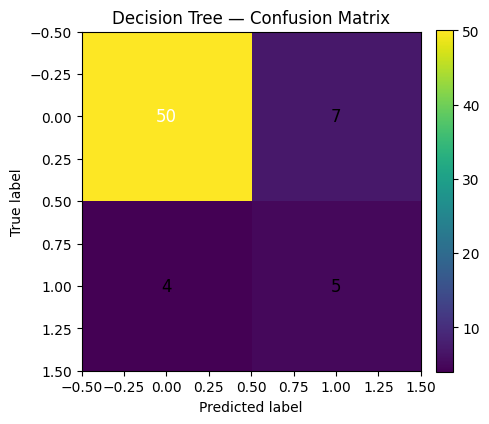

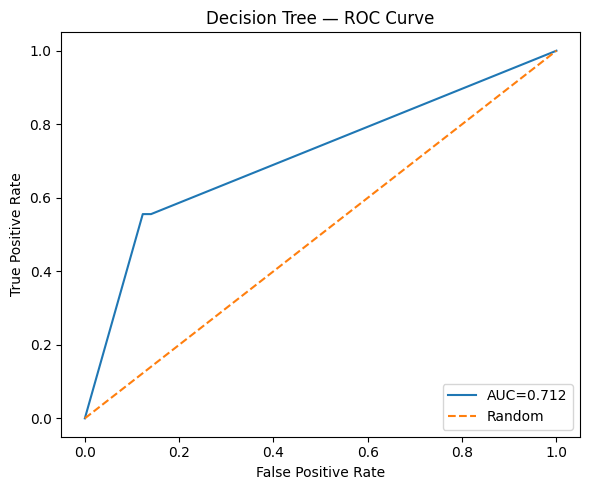

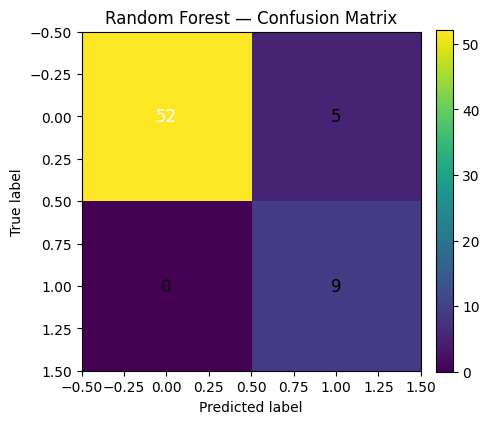

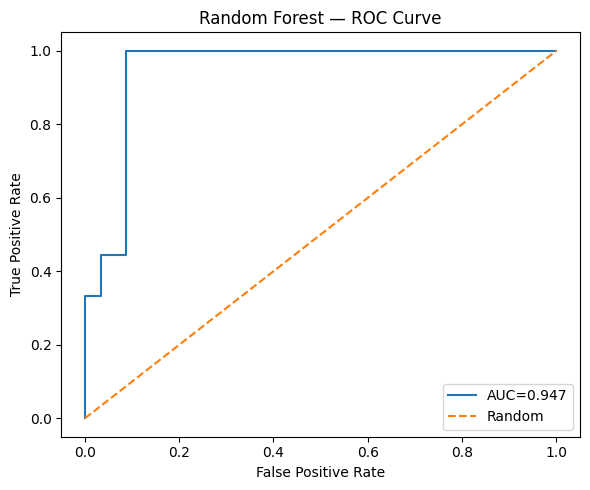

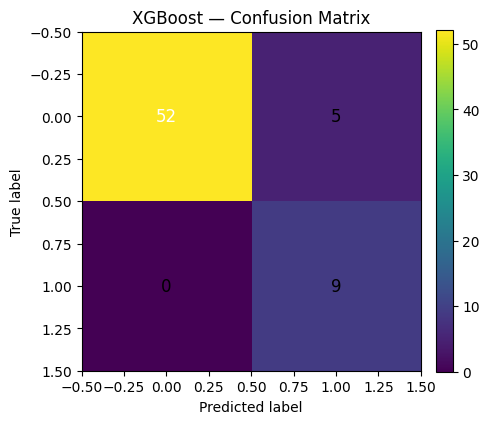

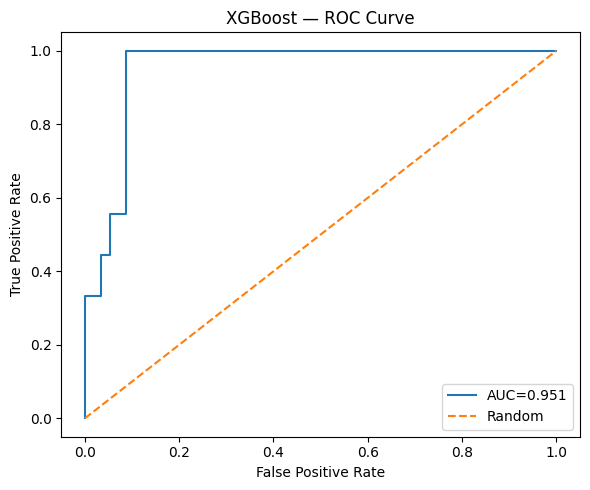

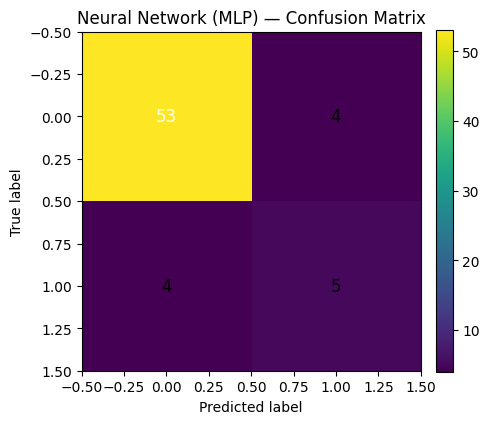

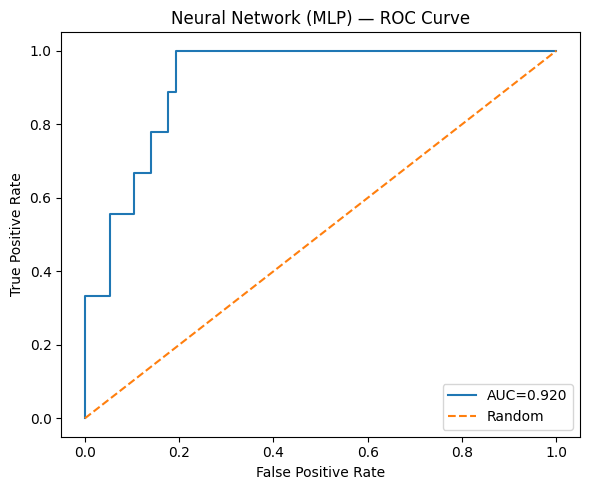

In [ ]:
# =========================
# 5) Train & evaluate helper
# =========================
def eval_model(name, model, Xtr, ytr, Xte, yte, out_prefix):
    model.fit(Xtr, ytr)
    y_pred = model.predict(Xte)

    # get scores
    acc = accuracy_score(yte, y_pred)
    pre = precision_score(yte, y_pred, zero_division=0)
    rec = recall_score(yte, y_pred, zero_division=0)
    f1  = f1_score(yte, y_pred, zero_division=0)

    # ROC AUC (need probabilities or decision function)
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(Xte)[:, 1]
    elif hasattr(model, "decision_function"):
        y_prob = model.decision_function(Xte)
    else:
        # fallback: use predictions (degrades to 0.5/0.5); acceptable only as last resort
        y_prob = y_pred.astype(float)

    auc = roc_auc_score(yte, y_prob)

    # ---- Confusion Matrix plot (saved)
    cm = confusion_matrix(yte, y_pred, labels=[0,1])
    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, cmap="viridis")
    ax.set_title(f"{name} — Confusion Matrix")
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    for (i, j), v in np.ndenumerate(cm):
        ax.text(j, i, int(v), ha="center", va="center", color="white" if v>np.max(cm)/2 else "black", fontsize=12)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    fig.tight_layout()
    cm_path = os.path.join(FIG_DIR, f"{out_prefix}_confusion.png")
    fig.savefig(cm_path, dpi=150, bbox_inches="tight")
    plt.show()

    # ---- ROC curve (saved)
    fpr, tpr, _ = roc_curve(yte, y_prob)
    fig, ax = plt.subplots(figsize=(6,5))
    ax.plot(fpr, tpr, label=f"AUC={auc:.3f}")
    ax.plot([0,1],[0,1], linestyle="--", label="Random")
    ax.set_title(f"{name} — ROC Curve")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right")
    fig.tight_layout()
    roc_path = os.path.join(FIG_DIR, f"{out_prefix}_roc.png")
    fig.savefig(roc_path, dpi=150, bbox_inches="tight")
    plt.show()

    return {
        "Model": name,
        "Accuracy": acc,
        "Precision": pre,
        "Recall": rec,
        "F1": f1,
        "ROC_AUC": auc,
        "TrainRows": len(Xtr),
        "TestRows": len(Xte),
        "EvalYear": int(df["Year"].iloc[0])
    }

results = []

# Decision Tree
results.append(
    eval_model("Decision Tree", dt, X_train, y_train, X_test, y_test, out_prefix="fig67_dt")
)

# Random Forest
results.append(
    eval_model("Random Forest", rf, X_train, y_train, X_test, y_test, out_prefix="fig69_rf")
)

# XGBoost (if available)
if HAS_XGB:
    results.append(
        eval_model("XGBoost", xgb, X_train, y_train, X_test, y_test, out_prefix="fig71_xgb")
    )

# MLP
results.append(
    eval_model("Neural Network (MLP)", mlp, X_train, y_train, X_test, y_test, out_prefix="fig73_mlp")
)


In [ ]:
# =========================
# 6) Table 7: results summary
# =========================
res_df = pd.DataFrame(results)
# Sort by ROC_AUC descending for display
res_df = res_df.sort_values("ROC_AUC", ascending=False).reset_index(drop=True)
display(res_df)

table7_path = os.path.join(TAB_DIR, "table7_model_results.csv")
res_df.to_csv(table7_path, index=False)
print("Saved Table 7 to:", table7_path)

print("\nSaved figures (look in your Drive 'figs' folder):")
print(" - Decision Tree: fig67_dt_confusion.png  |  fig67_dt_roc.png  (Figures 67 & 68)")
print(" - Random Forest: fig69_rf_confusion.png  |  fig69_rf_roc.png  (Figures 69 & 70)")
if HAS_XGB:
    print(" - XGBoost      : fig71_xgb_confusion.png |  fig71_xgb_roc.png (Figures 71 & 72)")
print(" - MLP          : fig73_mlp_confusion.png |  fig73_mlp_roc.png (Figures 73 & 74)")


,Model,Accuracy,Precision,Recall,F1,ROC_AUC,TrainRows,TestRows,EvalYear
0,XGBoost,0.924242,0.642857,1.000000,0.782609,0.951267,177,66,2017
1,Random Forest,0.924242,0.642857,1.000000,0.782609,0.947368,177,66,2017
2,Neural Network (MLP),0.878788,0.555556,0.555556,0.555556,0.920078,177,66,2017
3,Decision Tree,0.833333,0.416667,0.555556,0.476190,0.712476,177,66,2017


Saved Table 7 to: /content/drive/MyDrive/Infosys 722/tables/table7_model_results.csv

Saved figures (look in your Drive 'figs' folder):
 - Decision Tree: fig67_dt_confusion.png  |  fig67_dt_roc.png  (Figures 67 & 68)
 - Random Forest: fig69_rf_confusion.png  |  fig69_rf_roc.png  (Figures 69 & 70)
 - XGBoost      : fig71_xgb_confusion.png |  fig71_xgb_roc.png (Figures 71 & 72)
 - MLP          : fig73_mlp_confusion.png |  fig73_mlp_roc.png (Figures 73 & 74)
